In [24]:
import os
import pandas as pd
import numpy as np
drive_dir = '/content/drive/MyDrive/AIRI/Datasets'
os.chdir(drive_dir)
print("Google Drive directory:", os.getcwd())

Google Drive directory: /content/drive/MyDrive/AIRI/Datasets


# Univariate GBM
Uses estimates of mu, sigma, skew, curtosis and volatility clustering to simulate trajectories

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Union, Tuple
import matplotlib.pyplot as plt

class UnivariateGBMSimulator:
    def __init__(self, log_returns: np.ndarray, original_prices: np.ndarray = None):
        self.log_returns = log_returns
        self.original_prices = original_prices
        self.analyze_historical_properties()

    def analyze_historical_properties(self):
        self.daily_mu = np.mean(self.log_returns)
        self.daily_sigma = np.std(self.log_returns)
        self.mu = self.daily_mu * len(self.log_returns)
        self.sigma = self.daily_sigma * np.sqrt(len(self.log_returns))
        self.skew = stats.skew(self.log_returns)
        self.kurtosis = stats.kurtosis(self.log_returns)
        self.vol_cluster = np.corrcoef(
            np.abs(self.log_returns[1:]),
            np.abs(self.log_returns[:-1])
        )[0, 1]

    def simulate_returns(self,
                        n_days: int,
                        preserve_moments: bool = True
                        ) -> np.ndarray:
        if preserve_moments:
            log_returns = self._generate_johnson_returns(n_days)
        else:
            log_returns = np.random.normal(
                self.daily_mu,
                self.daily_sigma,
                n_days
            )

        if abs(self.vol_cluster) > 0.1:
            log_returns = self._add_volatility_clustering(log_returns)

        return log_returns

    def returns_to_price_path(self, returns: np.ndarray, initial_value: float = 1.0) -> np.ndarray:
        log_prices = np.log(initial_value) + np.cumsum(returns)
        prices = np.exp(log_prices)
        return np.insert(prices, 0, initial_value)

    def _generate_johnson_returns(self, n_days: int) -> np.ndarray:
        johnson_params = stats.johnsonsu.fit(self.log_returns)
        log_returns = stats.johnsonsu.rvs(*johnson_params, size=n_days)
        log_returns = (log_returns - np.mean(log_returns)) / np.std(log_returns)
        log_returns = log_returns * self.daily_sigma + self.daily_mu
        return log_returns

    def _add_volatility_clustering(self, log_returns: np.ndarray) -> np.ndarray:
        abs_returns = np.abs(log_returns)
        for i in range(1, len(log_returns)):
            abs_returns[i] = (
                abs_returns[i] * (1 - self.vol_cluster) +
                abs_returns[i-1] * self.vol_cluster
            )
        return np.sign(log_returns) * abs_returns

    def simulate_multiple_price_paths(self,
                                    n_paths: int,
                                    n_days: int,
                                    initial_value: float = 1.0,
                                    preserve_moments: bool = True
                                    ) -> pd.DataFrame:
        paths = np.zeros((n_days + 1, n_paths))

        for i in range(n_paths):
            returns = self.simulate_returns(n_days, preserve_moments)
            paths[:, i] = self.returns_to_price_path(returns, initial_value)

        return pd.DataFrame(paths, columns=[f'path_{i}' for i in range(n_paths)])

    def plot_simulations(self,
                        n_paths: int,
                        n_days: int,
                        initial_value: float = 1.0,
                        preserve_moments: bool = True):
        paths_df = self.simulate_multiple_price_paths(
            n_paths,
            n_days,
            initial_value,
            preserve_moments
        )

        plt.figure(figsize=(12, 6))

        for i in range(min(50, n_paths)):
            plt.plot(paths_df[f'path_{i}'],
                    alpha=0.1,
                    color='blue')

        mean_path = paths_df.mean(axis=1)
        percentile_5 = paths_df.quantile(0.05, axis=1)
        percentile_95 = paths_df.quantile(0.95, axis=1)

        plt.plot(mean_path,
                'r--',
                label='Mean Path',
                linewidth=2)

        plt.fill_between(paths_df.index,
                        percentile_5,
                        percentile_95,
                        color='gray',
                        alpha=0.2,
                        label='90% Confidence Interval')

        if self.original_prices is not None:
            scale_factor = initial_value / self.original_prices[0]
            scaled_original = self.original_prices * scale_factor

            min_length = min(len(scaled_original), len(paths_df))
            plt.plot(scaled_original[:min_length],
                    'g-',
                    label='Original Path',
                    linewidth=2)

        plt.title('Simulated Price Paths Based on Historical Properties')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        return paths_df

Example for synthetic data

Historical Properties:
Daily Drift (μ): -0.000178
Daily Volatility (σ): 0.009673
Annualized Drift: -0.0447
Annualized Volatility: 0.1535


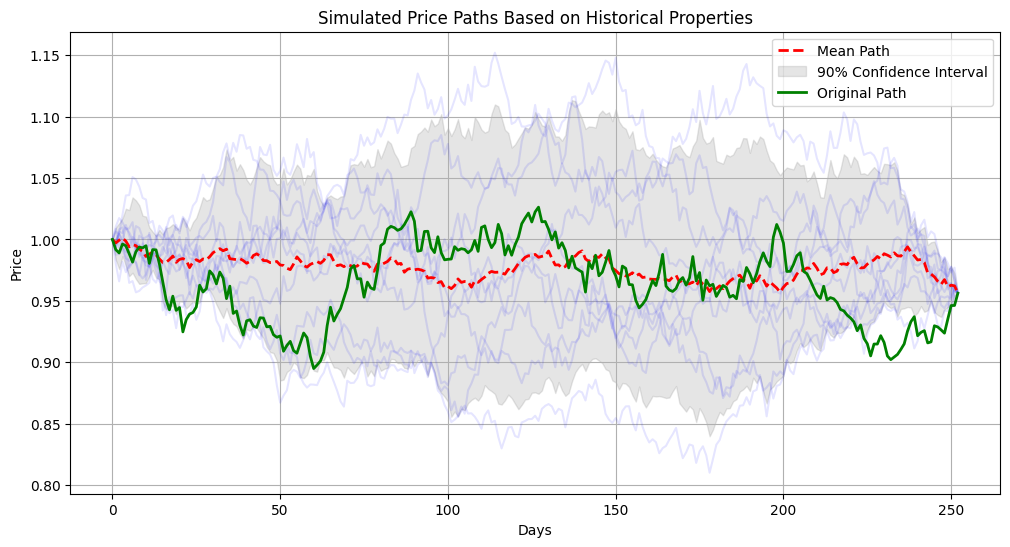

In [3]:
n_days = 252
time = np.arange(n_days + 1)
true_mu = 0.0001
true_sigma = 0.01

original_returns = np.random.normal(true_mu, true_sigma, n_days)
original_prices = np.exp(np.cumsum(np.insert(original_returns, 0, 0)))

simulator = UnivariateGBMSimulator(original_returns, original_prices)

print("Historical Properties:")
print(f"Daily Drift (μ): {simulator.daily_mu:.6f}")
print(f"Daily Volatility (σ): {simulator.daily_sigma:.6f}")
print(f"Annualized Drift: {simulator.mu:.4f}")
print(f"Annualized Volatility: {simulator.sigma:.4f}")

paths = simulator.plot_simulations(
    n_paths=10,
    n_days=n_days,
    initial_value=1.0,
    preserve_moments=True
)

Example for a real stock from S&P 500

In [4]:
sp = pd.read_csv('data/sp500_returns.csv')

In [5]:
sp

,Date,MOH,UAL,GOOG,AKAM,AES,MMM,FAST,MCO,MET,...,BIIB,ROP,ALL,TXT,PODD,ECL,LVS,EPAM,AIZ,TT
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,NaN,NaN,NaN,-0.068437,-0.040654,-0.040378,-0.056089,-0.028676,NaN,...,-0.069959,-0.046583,-0.032478,-0.016896,NaN,-0.026745,NaN,NaN,NaN,-0.020352
2,2000-01-05,NaN,NaN,NaN,-0.056570,0.010838,0.028127,0.043894,-0.018349,NaN,...,0.067381,-0.013218,0.043331,-0.024072,NaN,0.038093,NaN,NaN,NaN,-0.000935
3,2000-01-06,NaN,NaN,NaN,-0.182872,0.007846,0.077551,0.000000,0.000000,NaN,...,0.043554,0.000000,-0.005412,-0.012809,NaN,0.043470,NaN,NaN,NaN,0.052836
4,2000-01-07,NaN,NaN,NaN,0.050620,0.019149,0.019765,-0.006154,0.024391,NaN,...,0.108752,0.014599,0.036534,0.024019,NaN,0.000000,NaN,NaN,NaN,0.045955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2024-10-25,0.006008,0.001743,0.014841,-0.008107,-0.001191,-0.013686,0.008208,-0.008906,-0.023553,...,-0.011873,-0.000184,-0.020415,0.010498,-0.016976,-0.011180,0.005343,0.002824,-0.015317,0.000000
6244,2024-10-28,-0.032278,0.019240,0.008052,0.008593,0.005349,0.043446,0.010753,-0.001427,0.008398,...,0.018108,0.005758,0.005777,0.011110,-0.001113,0.011609,0.016233,-0.001202,0.012746,0.000484
6245,2024-10-29,0.024847,0.010979,0.016496,0.001069,-0.031309,-0.007824,0.012186,-0.003555,-0.003035,...,-0.008359,0.006728,-0.014051,-0.018178,-0.004294,-0.010545,-0.004316,0.013449,-0.003507,-0.005540
6246,2024-10-30,0.003275,0.044367,0.028797,-0.010839,-0.006135,-0.013308,0.009362,-0.003350,0.004125,...,-0.012560,-0.002883,0.015266,0.003540,-0.007733,-0.004582,-0.008687,-0.024911,0.007823,-0.039347


In [13]:
data = sp['MMM'].values[1000:2000]

Historical Properties:
Daily Drift (μ): -0.000178
Daily Volatility (σ): 0.009673
Total Drift: -0.0447
Total Volatility: 0.1535


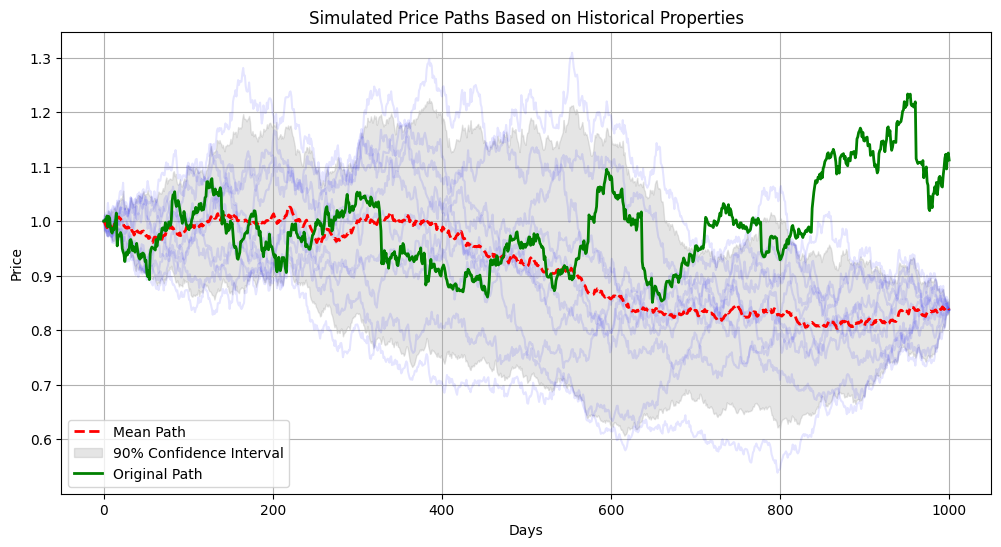

In [14]:
n_days = len(data)
time = np.arange(n_days + 1)
original_prices = np.exp(np.cumsum(np.insert(data, 0, 0)))

simulator = UnivariateGBMSimulator(original_returns, original_prices)

print("Historical Properties:")
print(f"Daily Drift (μ): {simulator.daily_mu:.6f}")
print(f"Daily Volatility (σ): {simulator.daily_sigma:.6f}")
print(f"Total Drift: {simulator.mu:.4f}")
print(f"Total Volatility: {simulator.sigma:.4f}")

paths = simulator.plot_simulations(
    n_paths=10,
    n_days=n_days,
    initial_value=1.0,
    preserve_moments=True
)

# Multivariate GBM  
Uses estimates of mu, sigma, skew, curtosis, volatility clustering and Cholesky decomposition for correlation to simulate trajectories. Can be used with either Normal or Johnson distribution, the latter is better for preserving curtosis and skew.

In [45]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Union, Tuple
import matplotlib.pyplot as plt

class MultivariateGBMSimulator:
    def __init__(self, log_returns: pd.DataFrame, original_prices: pd.DataFrame = None):
        self.log_returns = log_returns
        self.original_prices = original_prices
        self.n_assets = log_returns.shape[1]
        self.asset_names = log_returns.columns
        self.analyze_historical_properties()

    def analyze_historical_properties(self):
        self.daily_mu = self.log_returns.mean()
        self.daily_sigma = self.log_returns.std()

        self.mu = self.daily_mu * len(self.log_returns)
        self.sigma = self.daily_sigma * np.sqrt(len(self.log_returns))

        self.skew = stats.skew(self.log_returns)
        self.kurtosis = stats.kurtosis(self.log_returns)

        self.correlation = self.log_returns.corr()
        self.covariance = self.log_returns.cov()

        self.vol_cluster = pd.Series(index=self.asset_names)
        for asset in self.asset_names:
            self.vol_cluster[asset] = np.corrcoef(
                np.abs(self.log_returns[asset][1:]),
                np.abs(self.log_returns[asset][:-1])
            )[0, 1]

    def _generate_correlated_normals(self, n_days: int) -> pd.DataFrame:
        Z = np.random.normal(size=(n_days, self.n_assets))
        L = np.linalg.cholesky(self.correlation)
        correlated_vars = Z @ L.T

        # Scale by volatility and add drift
        for i, asset in enumerate(self.asset_names):
            correlated_vars[:, i] = (correlated_vars[:, i] * self.daily_sigma[asset]
                                   + self.daily_mu[asset])

        return pd.DataFrame(correlated_vars, columns=self.asset_names)

    def _generate_correlated_johnson(self, n_days: int) -> pd.DataFrame:
      johnson_rvs = pd.DataFrame(index=range(n_days), columns=self.asset_names)
      for asset in self.asset_names:
          asset_returns = self.log_returns[asset]
          johnson_params = stats.johnsonsu.fit(asset_returns)
          rvs = stats.johnsonsu.rvs(*johnson_params, size=n_days)

          # Standardize and rescale to match original moments
          rvs = (rvs - np.mean(rvs)) / np.std(rvs)
          johnson_rvs[asset] = rvs * self.daily_sigma[asset] + self.daily_mu[asset]

      values = johnson_rvs.values

      uniform_scores = np.zeros_like(values)
      for j in range(values.shape[1]):
          uniform_scores[:, j] = stats.rankdata(values[:, j]) / (n_days + 1)
      normal_scores = stats.norm.ppf(uniform_scores)
      L = np.linalg.cholesky(self.correlation)
      correlated_scores = normal_scores @ L.T
      result = pd.DataFrame(index=range(n_days), columns=self.asset_names)
      for i, asset in enumerate(self.asset_names):
          ranks = stats.rankdata(correlated_scores[:, i])
          sorted_rvs = np.sort(johnson_rvs[asset].values)
          result[asset] = sorted_rvs[ranks.astype(int) - 1]

      return result

    def _add_volatility_clustering(self, returns: pd.DataFrame) -> pd.DataFrame:
        clustered_returns = returns.copy()

        for asset in self.asset_names:
            if abs(self.vol_cluster[asset]) > 0.1:
                abs_returns = np.abs(clustered_returns[asset].values)
                for i in range(1, len(returns)):
                    abs_returns[i] = (
                        abs_returns[i] * (1 - self.vol_cluster[asset]) +
                        abs_returns[i-1] * self.vol_cluster[asset]
                    )
                clustered_returns[asset] = (
                    np.sign(clustered_returns[asset]) * abs_returns
                )

        return clustered_returns

    def simulate_returns(self,
                        n_days: int,
                        preserve_moments: bool = True
                        ) -> pd.DataFrame:
        if preserve_moments:
            returns = self._generate_correlated_johnson(n_days)
        else:
            returns = self._generate_correlated_normals(n_days)

        returns = self._add_volatility_clustering(returns)
        return returns

    def returns_to_price_paths(self,
                             returns: pd.DataFrame,
                             initial_values: pd.Series = None
                             ) -> pd.DataFrame:
        if initial_values is None:
            initial_values = pd.Series(1.0, index=self.asset_names)

        log_prices = np.log(initial_values) + returns.cumsum()
        prices = np.exp(log_prices)
        return pd.concat([initial_values.to_frame().T, prices])

    def simulate_multiple_price_paths(self,
                                    n_paths: int,
                                    n_days: int,
                                    initial_values: pd.Series = None,
                                    preserve_moments: bool = True
                                    ) -> dict:
        if initial_values is None:
            initial_values = pd.Series(1.0, index=self.asset_names)

        paths = {asset: pd.DataFrame() for asset in self.asset_names}

        for i in range(n_paths):
            returns = self.simulate_returns(n_days, preserve_moments)
            prices = self.returns_to_price_paths(returns, initial_values)

            for asset in self.asset_names:
                paths[asset][f'path_{i}'] = prices[asset]

        return paths

    def plot_simulations(self,
                        n_paths: int,
                        n_days: int,
                        initial_values: pd.Series = None,
                        preserve_moments: bool = True):
        paths_dict = self.simulate_multiple_price_paths(
            n_paths, n_days, initial_values, preserve_moments
        )

        n_assets = len(self.asset_names)
        fig, axes = plt.subplots(n_assets, 1, figsize=(12, 6*n_assets))
        if n_assets == 1:
            axes = [axes]

        for ax, asset in zip(axes, self.asset_names):
            paths_df = paths_dict[asset]
            paths_df = paths_df.reset_index(drop=True)

            for i in range(min(50, n_paths)):
                ax.plot(paths_df[f'path_{i}'],
                       alpha=0.1,
                       color='blue')

            mean_path = paths_df.mean(axis=1)
            mean_path = mean_path.reset_index(drop=True)
            percentile_5 = paths_df.quantile(0.05, axis=1)
            percentile_95 = paths_df.quantile(0.95, axis=1)
            ax.plot(mean_path,
                   'r--',
                   label='Mean Path',
                   linewidth=2)

            ax.fill_between(paths_df.index,
                          percentile_5,
                          percentile_95,
                          color='gray',
                          alpha=0.2,
                          label='90% Confidence Interval')

            if self.original_prices is not None:
                original = self.original_prices[asset]
                if initial_values is not None:
                    scale_factor = initial_values[asset] / original.iloc[0]
                    original = original * scale_factor

                min_length = min(len(original), len(paths_df))
                ax.plot(original[:min_length],
                       'g-',
                       label='Original Path',
                       linewidth=2)

            ax.set_title(f'Simulated Price Paths for {asset}')
            ax.set_xlabel('Days')
            ax.set_ylabel('Price')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

        return paths_dict

In [26]:
sp = pd.read_csv('data/sp500_returns.csv')

In [27]:
sp

,Date,MOH,UAL,GOOG,AKAM,AES,MMM,FAST,MCO,MET,...,BIIB,ROP,ALL,TXT,PODD,ECL,LVS,EPAM,AIZ,TT
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,NaN,NaN,NaN,-0.068437,-0.040654,-0.040378,-0.056089,-0.028676,NaN,...,-0.069959,-0.046583,-0.032478,-0.016896,NaN,-0.026745,NaN,NaN,NaN,-0.020352
2,2000-01-05,NaN,NaN,NaN,-0.056570,0.010838,0.028127,0.043894,-0.018349,NaN,...,0.067381,-0.013218,0.043331,-0.024072,NaN,0.038093,NaN,NaN,NaN,-0.000935
3,2000-01-06,NaN,NaN,NaN,-0.182872,0.007846,0.077551,0.000000,0.000000,NaN,...,0.043554,0.000000,-0.005412,-0.012809,NaN,0.043470,NaN,NaN,NaN,0.052836
4,2000-01-07,NaN,NaN,NaN,0.050620,0.019149,0.019765,-0.006154,0.024391,NaN,...,0.108752,0.014599,0.036534,0.024019,NaN,0.000000,NaN,NaN,NaN,0.045955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2024-10-25,0.006008,0.001743,0.014841,-0.008107,-0.001191,-0.013686,0.008208,-0.008906,-0.023553,...,-0.011873,-0.000184,-0.020415,0.010498,-0.016976,-0.011180,0.005343,0.002824,-0.015317,0.000000
6244,2024-10-28,-0.032278,0.019240,0.008052,0.008593,0.005349,0.043446,0.010753,-0.001427,0.008398,...,0.018108,0.005758,0.005777,0.011110,-0.001113,0.011609,0.016233,-0.001202,0.012746,0.000484
6245,2024-10-29,0.024847,0.010979,0.016496,0.001069,-0.031309,-0.007824,0.012186,-0.003555,-0.003035,...,-0.008359,0.006728,-0.014051,-0.018178,-0.004294,-0.010545,-0.004316,0.013449,-0.003507,-0.005540
6246,2024-10-30,0.003275,0.044367,0.028797,-0.010839,-0.006135,-0.013308,0.009362,-0.003350,0.004125,...,-0.012560,-0.002883,0.015266,0.003540,-0.007733,-0.004582,-0.008687,-0.024911,0.007823,-0.039347


In [28]:
def select_single_nan_stocks(df: pd.DataFrame) -> pd.DataFrame:
    nan_counts = df.isna().sum()
    single_nan_cols = nan_counts[nan_counts == 1].index
    return df[single_nan_cols].dropna()

In [29]:
single_nan_stocks = select_single_nan_stocks(sp)

In [30]:
single_nan_stocks

,AKAM,AES,MMM,FAST,MCO,ROL,CMCSA,MHK,GWW,PLD,...,ADP,WY,MAS,HON,BIIB,ROP,ALL,TXT,ECL,TT
1,-0.068437,-0.040654,-0.040378,-0.056089,-0.028676,-0.015748,-0.077718,-0.023065,-0.029192,-0.016894,...,0.000000,-0.037706,-0.024634,-0.017682,-0.069959,-0.046583,-0.032478,-0.016896,-0.026745,-0.020352
2,-0.056570,0.010838,0.028127,0.043894,-0.018349,0.000000,-0.026642,0.018167,0.013863,-0.011866,...,-0.009856,0.051705,-0.041895,-0.013637,0.067381,-0.013218,0.043331,-0.024072,0.038093,-0.000935
3,-0.182872,0.007846,0.077551,0.000000,0.000000,0.000000,0.038259,-0.005333,-0.004038,0.018397,...,0.013120,0.045018,0.010017,0.019238,0.043554,0.000000,-0.005412,-0.012809,0.043470,0.052836
4,0.050620,0.019149,0.019765,-0.006154,0.024391,0.015748,-0.032277,0.012671,-0.015288,0.019343,...,0.022554,-0.032928,0.036694,0.052163,0.108752,0.014599,0.036534,0.024019,0.000000,0.045955
5,0.139282,0.044206,-0.005139,-0.025001,0.000000,0.015504,0.120651,0.007688,0.042560,0.006365,...,0.024391,-0.004301,-0.028423,0.005287,0.098328,0.009615,-0.023442,0.012152,0.020054,-0.021414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,-0.008107,-0.001191,-0.013686,0.008208,-0.008906,0.001294,0.000240,-0.148744,0.008039,-0.023958,...,-0.005092,-0.010324,-0.019689,-0.005300,-0.011873,-0.000184,-0.020415,0.010498,-0.011180,0.000000
6244,0.008593,0.005349,0.043446,0.010753,-0.001427,0.015401,0.004311,0.006322,0.012020,0.002294,...,-0.005292,0.004706,0.005051,-0.009173,0.018108,0.005758,0.005777,0.011110,0.011609,0.000484
6245,0.001069,-0.031309,-0.007824,0.012186,-0.003555,0.001273,0.005482,0.005301,-0.005249,-0.021449,...,0.005258,-0.034063,-0.004557,-0.000585,-0.008359,0.006728,-0.014051,-0.018178,-0.010545,-0.005540
6246,-0.010839,-0.006135,-0.013308,0.009362,-0.003350,-0.010871,0.004033,0.021517,0.000893,0.004845,...,0.016635,0.026839,-0.011796,-0.008673,-0.012560,-0.002883,0.015266,0.003540,-0.004582,-0.039347



Correlation Matrix:
         MMM   FAST    ROL  CMCSA    MHK    PLD    ADP
MMM    1.000  0.462  0.373  0.419  0.463  0.421  0.478
FAST   0.462  1.000  0.403  0.402  0.410  0.428  0.431
ROL    0.373  0.403  1.000  0.355  0.307  0.397  0.394
CMCSA  0.419  0.402  0.355  1.000  0.382  0.392  0.436
MHK    0.463  0.410  0.307  0.382  1.000  0.439  0.371
PLD    0.421  0.428  0.397  0.392  0.439  1.000  0.414
ADP    0.478  0.431  0.394  0.436  0.371  0.414  1.000

Annualized Statistics:
Mean Returns:
MMM      1.869
FAST     3.858
ROL      4.296
CMCSA    1.370
MHK      1.699
PLD      2.678
ADP      2.470
dtype: float64

Volatility:
MMM      1.217
FAST     1.623
ROL      1.496
CMCSA    1.589
MHK      1.940
PLD      1.873
ADP      1.250
dtype: float64

Volatility Clustering:
MMM      0.189
FAST     0.198
ROL      0.270
CMCSA    0.272
MHK      0.213
PLD      0.474
ADP      0.248
dtype: float64

Running simulations...

Plotting normal distribution simulation...


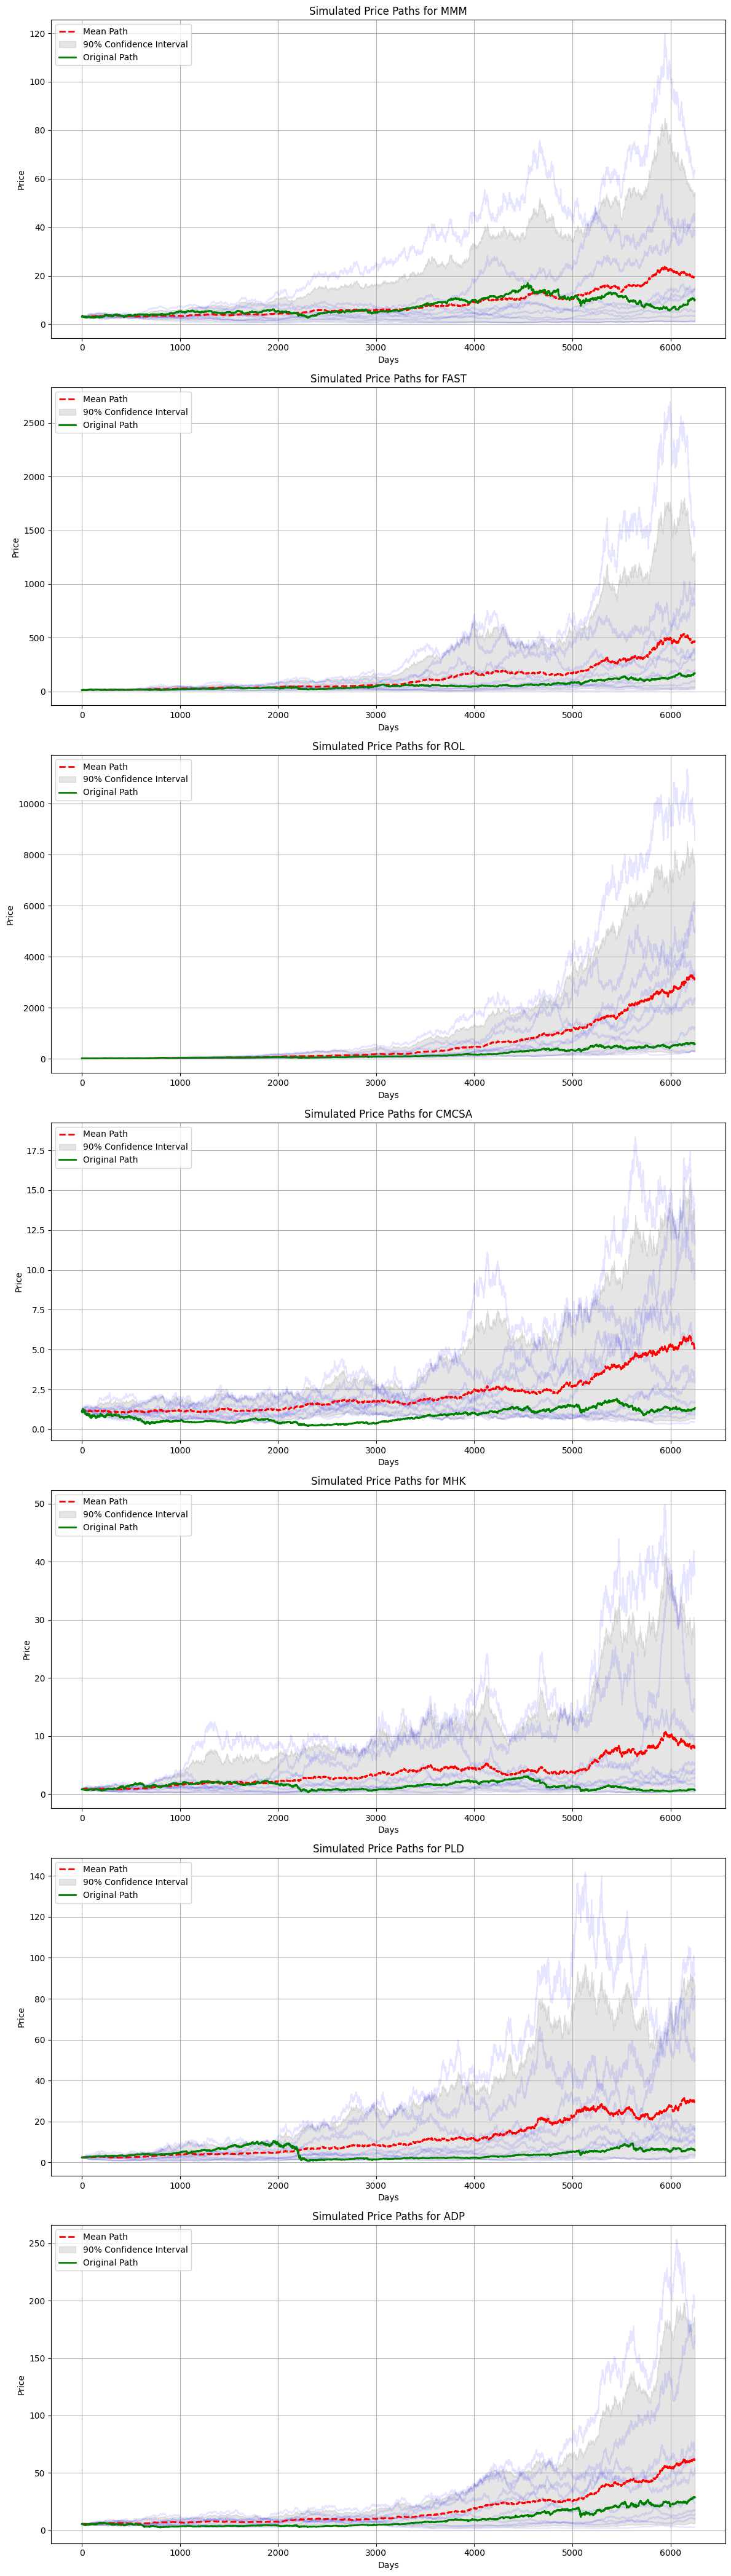


Plotting Johnson distribution simulation...


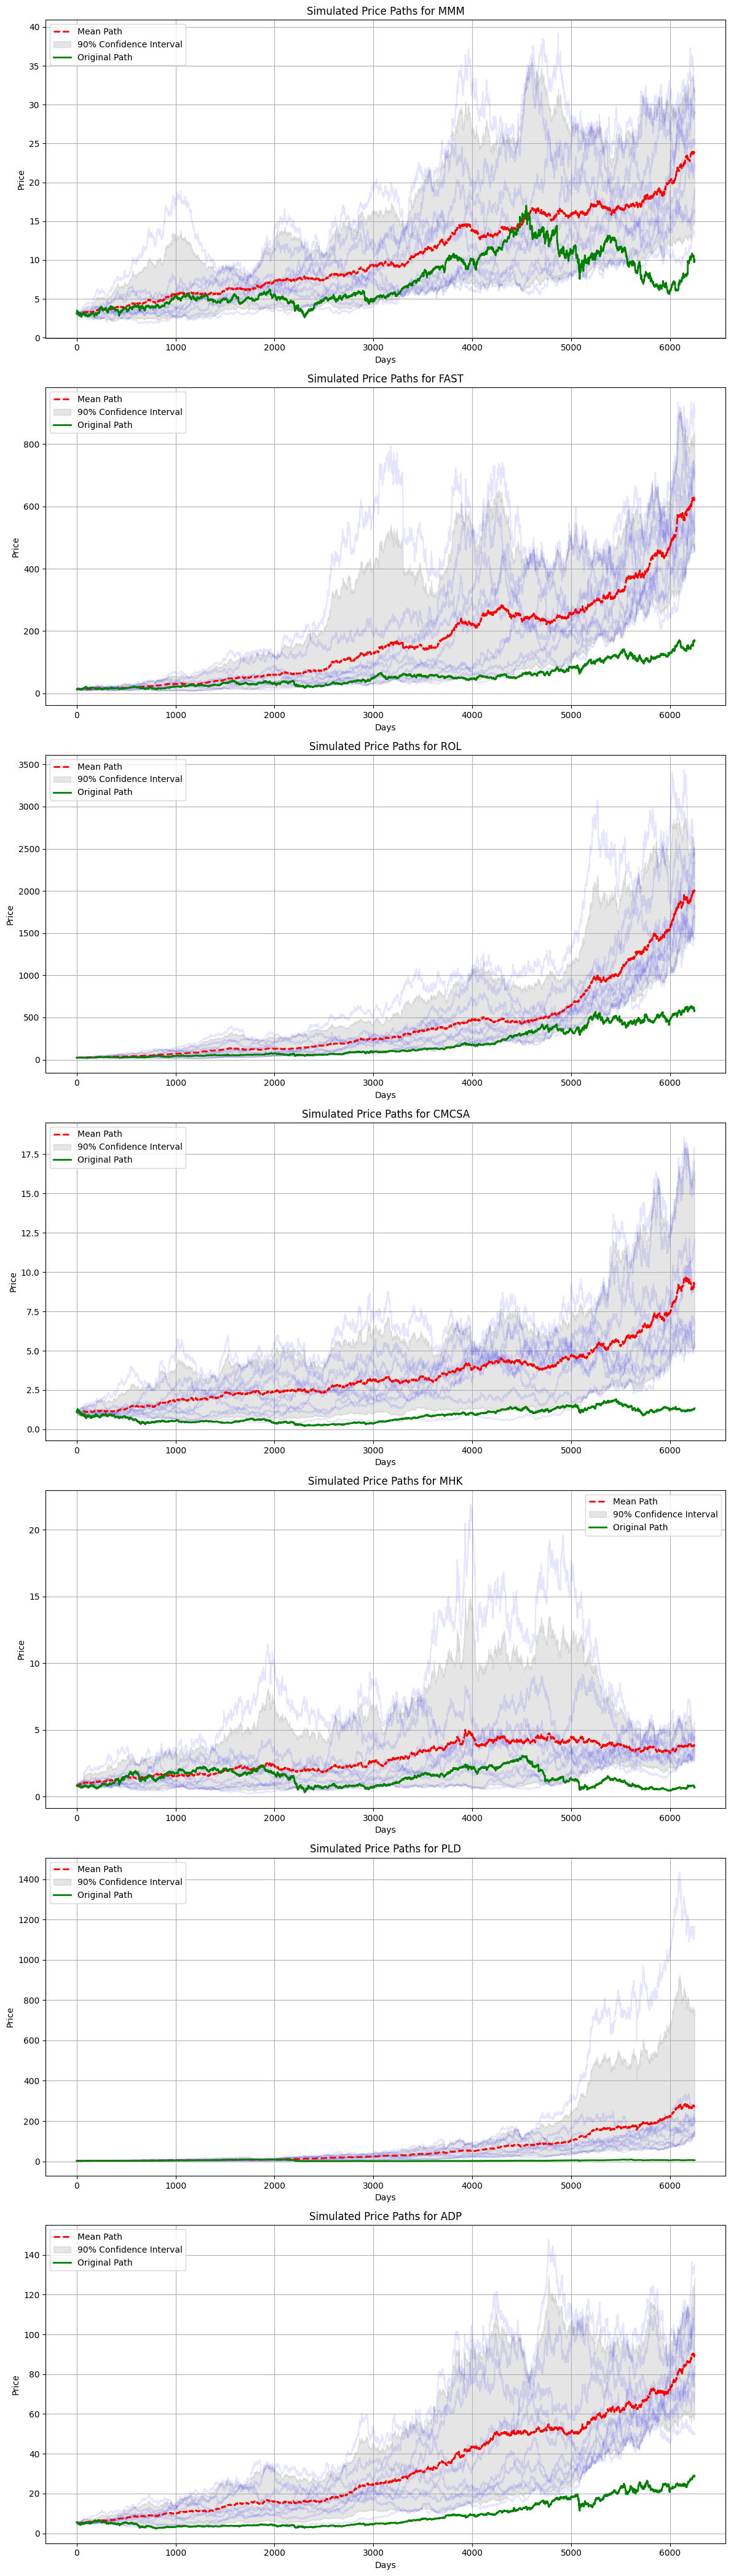


Normal Distribution Simulation Analysis:
               MMM    FAST     ROL   CMCSA      MHK      PLD      ADP
Sim Mean    0.0005  0.0010  0.0009  0.0005   0.0007   0.0007   0.0007
Hist Mean   0.0003  0.0006  0.0007  0.0002   0.0003   0.0004   0.0004
Sim Vol     0.0145  0.0192  0.0173  0.0186   0.0229   0.0207   0.0146
Hist Vol    0.0154  0.0205  0.0189  0.0201   0.0245   0.0237   0.0158
Sim Skew    0.0110  0.0334  0.0125  0.0225   0.0415   0.0075   0.0160
Hist Skew   0.1463  0.0614 -0.1209 -0.0168  -0.2756  -0.9848  -1.0324
Sim Kurt   -0.4730 -0.5168 -0.7098 -0.6926  -0.5655  -1.1588  -0.6280
Hist Kurt  11.7481  6.3246  7.4043  8.3628  13.7567  31.7715  21.3903

Johnson Distribution Simulation Analysis:
               MMM    FAST     ROL   CMCSA      MHK      PLD      ADP
Sim Mean    0.0004  0.0008  0.0008  0.0004   0.0005   0.0010   0.0005
Hist Mean   0.0003  0.0006  0.0007  0.0002   0.0003   0.0004   0.0004
Sim Vol     0.0140  0.0186  0.0166  0.0176   0.0221   0.0182   0.0140
Hist 

In [46]:
stocks = ['MMM', 'FAST', 'ROL', 'CMCSA', 'MHK', 'PLD', 'ADP']
returns = single_nan_stocks[stocks].dropna()


prices = (1 + returns).cumprod()

simulator = MultivariateGBMSimulator(
    log_returns=returns,
    original_prices=prices
)

print("\nCorrelation Matrix:")
print(simulator.correlation.round(3))

print("\nAnnualized Statistics:")
print("Mean Returns:")
print(simulator.mu.round(3))
print("\nVolatility:")
print(simulator.sigma.round(3))
print("\nVolatility Clustering:")
print(simulator.vol_cluster.round(3))


n_paths = 10
n_days = len(prices)


initial_values = prices.iloc[-1]

print("\nRunning simulations...")

normal_paths = simulator.simulate_multiple_price_paths(
    n_paths=n_paths,
    n_days=n_days,
    initial_values=initial_values,
    preserve_moments=False
)

johnson_paths = simulator.simulate_multiple_price_paths(
    n_paths=n_paths,
    n_days=n_days,
    initial_values=initial_values,
    preserve_moments=True
)

print("\nPlotting normal distribution simulation...")
simulator.plot_simulations(
    n_paths=n_paths,
    n_days=n_days,
    initial_values=initial_values,
    preserve_moments=False
)

print("\nPlotting Johnson distribution simulation...")
simulator.plot_simulations(
    n_paths=n_paths,
    n_days=n_days,
    initial_values=initial_values,
    preserve_moments=True
)

def analyze_results(paths_dict: dict, original_prices: pd.DataFrame):
    results = pd.DataFrame()

    for asset in paths_dict.keys():
        sim_returns = paths_dict[asset].pct_change().iloc[1:]
        hist_returns = original_prices[asset].pct_change().dropna()
        results.loc['Sim Mean', asset] = sim_returns.mean().mean()
        results.loc['Hist Mean', asset] = hist_returns.mean()
        results.loc['Sim Vol', asset] = sim_returns.std().mean()
        results.loc['Hist Vol', asset] = hist_returns.std()
        results.loc['Sim Skew', asset] = sim_returns.skew().mean()
        results.loc['Hist Skew', asset] = hist_returns.skew()
        results.loc['Sim Kurt', asset] = sim_returns.kurtosis().mean()
        results.loc['Hist Kurt', asset] = hist_returns.kurtosis()

    return results.round(4)

print("\nNormal Distribution Simulation Analysis:")
normal_analysis = analyze_results(normal_paths, prices)
print(normal_analysis)

print("\nJohnson Distribution Simulation Analysis:")
johnson_analysis = analyze_results(johnson_paths, prices)
print(johnson_analysis)